In [2]:
import numpy as np
from numba import njit
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from solvers import implicit_scheme, direct_simulation
from utils import show_qqplot, brownian_paths

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


- check if oversteps $T$
    - Decrease step
        - calculate $Y_{n+1}$ (explicit)
            - $Y_{n+1} < 0$
                - Apply implicit method
- check if $h < h_{min}$
    - set $h = h_{min}$
    - Apply implicit method
- calculate $Y_{n+1}$ (explicit)
    - $Y_{n+1} < 0$
        - Apply implicit method

In [18]:
#@njit
def adaptive_vectorized(k, lamda, theta, X_0, T, h_max, h_min, r, M):
    alpha = (4*k*lamda - theta**2)/8
    beta = -k/2
    gamma = theta/2
    
    max_steps = int(T[-1]//h_min + 1)
    t = np.zeros((max_steps, M))
    Y = np.zeros((max_steps, M))
    std_n = np.random.randn(max_steps, M)
    
    #backstop_usage = np.zeros((max_steps, M))
    
    Y[0] = np.sqrt(X_0)

    #def backstop(Y_prev, dt, dW):
    #    #dW = std_n[j-1, i] * np.sqrt(dt)
    #    Y_next = np.zeros(Y_prev.shape)
    #    d = (Y_prev + gamma*dW)**2/(4*(1-beta*dt)**2) \
    #                + (alpha*dt)/(1-beta*dt) # discriminant
    #    Y_next[d > 0] = (Y_prev[d > 0] + gamma*dW[d > 0])/(2*(1-beta*dt[d > 0])) \
    #                 + np.sqrt(
    #                     d[d > 0]
    #                 )
    #    return Y_next
    #
    #def explicit_step(Y_prev, dt, dW):
    #    #dW = std_n[j-1, i] * np.sqrt(dt)
    #    return Y_prev + dt*(alpha/Y_prev + beta*Y_prev) + gamma * dW
    
    next_T_index = np.zeros(M, dtype=np.int64)
    for j in range(1, max_steps):
        h = h_max * np.minimum(1, np.abs(Y[j-1])**r)
        T_next = T[next_T_index]
        
        # Event that a path has gone beyond time T[-1]
        past_T = t[j-1] >= T[-1] 
        
        # Event that a smaller step must be taken to reach next_T
        overshoot = (t[j-1] + h >= T_next) & ~past_T
        
        # Event that h < h_min
        small = h < h_min 
        
        # Event that implicit method should be applied directly
        # (small) \ (overshoot)
        direct_imp = small & ~overshoot
        
        # Choose h_min as time step
        dt = np.full(direct_imp.sum(), h_min)
        dW = std_n[j-1, direct_imp] * np.sqrt(h_min)
        Y[j,direct_imp] = backstop(Y[j-1,direct_imp], 
                                   dt, 
                                   dW)
        
        # Decrease step in event of overshoot
        h[overshoot] = T_next[overshoot] - t[j-1, overshoot]
        
        # In all other cases we first apply explicit
        # And recalculate using implicit if explicit produces 
        # negative answer
        
        # Previous Y where explicit should be applied
        try_explicit = ~direct_imp
        
        Y_prev_exp = Y[j-1,try_explicit] 
        
        # Step sizes
        h_exp = h[try_explicit]
        dW = std_n[j-1, try_explicit] * np.sqrt(h_exp)
        
        # Apply explicit, and apply implict to values that go negative
        Y_next_exp = explicit_step(Y_prev_exp, h_exp, dW)
        Y_next_exp[Y_next_exp<0] = backstop(Y_prev_exp[Y_next_exp<0], 
                                            h_exp[Y_next_exp<0], 
                                            dW[Y_next_exp<0])
        Y[j,try_explicit] = Y_next_exp
        
        # Record current timestep for each path
        t[j] = t[j-1] + h
        
        # If T_next exceeded, move to the next T_next
        next_T_index = np.minimum(next_T_index + (t[j] >= T_next), 
                                  T.shape[0] - 1)
        
        # If all paths go beyond final time
        if (t[j] >= T[-1]).all():
            break
    
    X = Y**2
    return t[:j+1], X[:j+1]

In [21]:
%%time
#np.random.seed(0)
k, lamda, theta, X_0, T, h_max, h_min, r, M = 1, 1, 1, 1, np.array([1]), 1/10000, 1/100000, 1, 1000
t, X = adaptive_vectorized(k, lamda, theta, X_0, T, h_max, h_min, r, M)

Wall time: 13 s


In [11]:
np.random.normal(0, 1, 0)

array([], dtype=float64)

(0, 1)

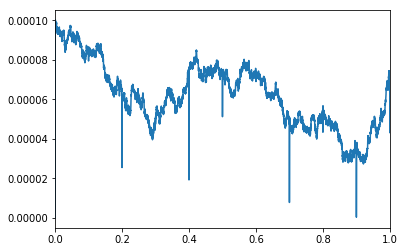

In [7]:
plt.plot(t[1:,1], np.diff(t[:,1]))
plt.xlim(0, 1)

In [70]:
@njit
def test():
    alpha, beta, gamma, Y_prev, dt, dW = 1,1,1,np.ones(2), np.array([0.01,0.01]), np.array([0.01,0.01])
    def backstop(alpha, beta, gamma, Y_prev, dt, dW):
        #dW = std_n[j-1, i] * np.sqrt(dt)
        Y_next = np.zeros(Y_prev.shape)
        #set_trace()
        d = (Y_prev + gamma*dW)**2/(4*(1-beta*dt)**2) + (alpha*dt)/(1-beta*dt) # discriminant
        Y_next[d > 0] = (Y_prev[d > 0] + gamma*dW[d > 0])/(2*(1-beta*dt[d > 0])) \
                     + np.sqrt(
                         d[d > 0]
                     )
        return Y_next
    print(backstop(alpha, beta, gamma, Y_prev, dt, dW))

In [188]:
@njit
def test():
    a = np.array([1,1])
    #def f(b):
    #    d = b/b
    #    return d
    print(a/a)

In [189]:
test()

[1. 1.]


Choosing step size

\< final time, no overshoot, h > h_min  
\< final time, overshoot, h > h_min  
\> final time, h > h_min  


In [ ]:
i = 10
show_qqplot(k, lamda, theta, X_0, T[i], X[t == T[i]])

In [75]:
np.empty((3,2))

array([[1.09912079e-14, 1.09912079e-14],
       [1.09912079e-14, 1.09912079e-14],
       [1.09912079e-14, 1.09912079e-14]])

Apply implicit if:  
  
\< final time, no overshoot, h < h_min  
or  
\>= final time, h < h_min  

In [5]:
@njit
def _implicit_step(alpha, beta, gamma, Y_prev, dt, dW):
    Y_next = np.zeros(Y_prev.shape)

    d = (Y_prev + gamma*dW)**2/(4*(1-beta*dt)**2) + (alpha*dt)/(1-beta*dt) # discriminant
    Y_next[d > 0] = (Y_prev[d > 0] + gamma*dW[d > 0])/(2*(1-beta*dt[d > 0])) \
                 + np.sqrt(
                     d[d > 0]
                 )
    return Y_next
    
@njit
def _explicit_step(alpha, beta, gamma, Y_prev, dt, dW):
    return Y_prev + dt*(alpha/Y_prev + beta*Y_prev) + gamma * dW    

In [52]:
%timeit np.zeros(1000)

912 ns ± 19.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [106]:
@njit
def adaptive_vectorized_jit(k, lamda, theta, X_0, T, h_max, h_min, r, M):
    alpha = (4*k*lamda - theta**2)/8
    beta = -k/2
    gamma = theta/2
    
    max_steps = int(T[-1]//h_min + 1)
    t = np.zeros((max_steps, M))
    Y = np.zeros((max_steps, M))
    std_n = np.random.randn(max_steps, M)
    
    #backstop_usage = np.zeros((max_steps, M))
    
    Y[0] = np.sqrt(X_0)

    #def backstop(alpha, beta, gamma, Y_prev, dt, dW):
    #    #dW = std_n[j-1, i] * np.sqrt(dt)
    #    Y_next = np.zeros(Y_prev.shape)
    #    #set_trace()
    #    d = (Y_prev + gamma*dW)**2/(4*(1-beta*dt)**2) + (alpha*dt)/(1-beta*dt) # discriminant
    #    Y_next[d > 0] = (Y_prev[d > 0] + gamma*dW[d > 0])/(2*(1-beta*dt[d > 0])) \
    #                 + np.sqrt(
    #                     d[d > 0]
    #                 )
    #    return Y_next
    #
    #def explicit_step(alpha, beta, gamma, Y_prev, dt, dW):
    #    #dW = std_n[j-1, i] * np.sqrt(dt)
    #    return Y_prev + dt*(alpha/Y_prev + beta*Y_prev) + gamma * dW
    
    next_T_index = np.zeros(M, dtype=np.int64)
    finished_paths = 0
    for j in range(1, max_steps):
        
        t_last = t[j-1]

        active = (t_last < T[-1])
        if not active.any():
            break

        Y_next = np.zeros(M)
        
        Y_last = Y[j-1]
        
        T_next = T[next_T_index]
        std_n_next = std_n[j-1]
        
        h = h_max * np.minimum(1, np.abs(Y_last)**r)

        # Event that a smaller step must be taken to reach next_T
        overshoot = (t_last + h > T_next) & active
        
        # Event that h < h_min
        small = (h < h_min) & active
        
        # Event that implicit method should be applied directly
        # (small) \ (overshoot)
        direct_imp = small & ~overshoot
        #if direct_imp.any():
            # Choose h_min as time step
        dW = std_n_next[direct_imp] * np.sqrt(h_min)
        dt = np.full(len(dW), h_min)
        
        Y_next[direct_imp] = _implicit_step(alpha, beta, gamma, Y_last[direct_imp], 
                                        dt, 
                                        dW)

        h[direct_imp] = h_min
        
        # Decrease step in event of overshoot
        h[overshoot] = T_next[overshoot] - t_last[overshoot]
        
        # In all other cases we first apply explicit
        # And recalculate using implicit if explicit produces 
        # negative answer
        
        # Previous Y where explicit should be applied
        try_explicit = ~direct_imp & active
        
        #Y_prev_exp = Y[try_explicit] 
        
        # Step sizes
        #if try_explicit.any():
        h_exp = h[try_explicit]
        dW = std_n_next[try_explicit] * np.sqrt(h_exp)

        # Apply explicit, and apply implict to values that go negative
        Y_next[try_explicit]  = _explicit_step(alpha, beta, gamma, Y_last[try_explicit], 
                                              h_exp, 
                                              dW)
        neg_fix = Y_next<0
            #if neg_fix.any():
        h_neg_fix = h[neg_fix]
        dW_neg_fix = std_n_next[neg_fix] * np.sqrt(h_neg_fix)
        Y_next[neg_fix] = _implicit_step(alpha, beta, gamma, Y_last[neg_fix],   
                                   h_neg_fix,    
                                   dW_neg_fix)
        Y[j] = Y_next
        #Y[j,try_explicit] = Y_next_exp
        
        # Record current timestep for each path
        #t_next = t_last + h
        #t_next[~active] = -1
        t[j] = t_last + h
        #t[j][~active] = -1
        # If T_next exceeded, move to the next T_next
        next_T_index = np.minimum(next_T_index + (t[j] >= T_next), 
                                  T.shape[0] - 1)
        #finished_paths += (t[j] >= T[-1]).sum()
        #if finished_paths == M:
        #    break
    X = Y**2 
    #X[t==T[-1]] = -1
    return t[:j], X[:j]

In [107]:
%%time
np.random.seed(0)
k, lamda, theta, X_0, T, h_max, h_min, r, M = 1, 1, 1, 1, np.array([1]), 1/10000, 1/100000, 1, 1000
t, X = adaptive_vectorized_jit(k, lamda, theta, X_0, T, h_max, h_min, r, M)

Wall time: 8.04 s


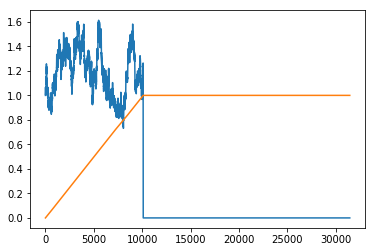

In [100]:
tt, XX = t[:,0], X[:,0]
plt.plot(XX)
plt.plot(tt)

In [41]:
XX[15238]

0.0

In [39]:
np.where(tt==1)

(array([15237], dtype=int64),)